# Data Generation

In [37]:
import numpy as np
import pennylane as qml
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate dataset
X, y = make_moons(n_samples=100, noise=0.1)

# Normalize dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels from {0,1} to {-1,1} for quantum compatibility
y = 2 * y - 1  

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print sample points
print(f"First 5 training samples: {X_train[:5]}")
print(f"First 5 training labels: {y_train[:5]}")


First 5 training samples: [[-4.40834423e-01  1.93526909e+00]
 [-6.69120179e-01  1.67282699e-01]
 [ 8.20969500e-04  1.08513364e+00]
 [-1.51206383e-01 -1.38952818e+00]
 [-1.37478923e+00 -1.20376447e-01]]
First 5 training labels: [-1  1 -1  1 -1]


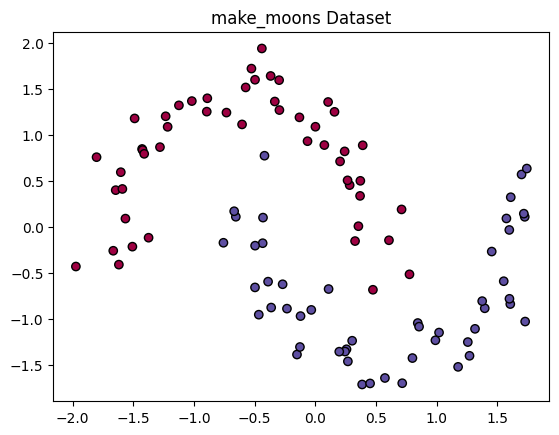

In [38]:
# Plot the dataset
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')
plt.title("make_moons Dataset")
plt.show()


# Data Encoding

In [39]:
# Define the quantum device (using 1 qubit since we encode 2D data in rotations)
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum feature embedding (Angle Encoding)
def feature_map(x):
    """Encodes classical data into quantum states."""
    qml.RY(x[0], wires=0)  # Encode first feature with RY
    qml.RZ(x[1], wires=0)  # Encode second feature with RZ

# Test encoding with a sample
x_sample = X_train[0]
print(f"Encoding sample: {x_sample}")

@qml.qnode(dev)
def test_encoding(x):
    feature_map(x)
    return qml.state()

# Print quantum state after encoding
print(f"Quantum state: {test_encoding(x_sample)}")


Encoding sample: [-0.44083442  1.93526909]
Quantum state: [ 0.55352533-0.8036216j  -0.12402152-0.18005748j]


# Circuit implementation

In [40]:
# Define variational quantum circuit
def variational_circuit(params):
    """Parameterized quantum circuit (trainable part)."""
    qml.RY(params[0], wires=0)  # Trainable rotation around Y
    qml.RZ(params[1], wires=0)  # Trainable rotation around Z

# Define full QVC circuit
@qml.qnode(dev)
def qvc_circuit(x, params):
    """Quantum variational classifier circuit."""
    feature_map(x)  # Encode classical data into quantum state
    variational_circuit(params)  # Apply trainable quantum circuit
    return qml.expval(qml.PauliZ(0))  # Measure expectation value

# Test circuit with random parameters
params_test = np.random.randn(2)  # Two trainable parameters
print(f"Test params: {params_test}")

# Run the QVC circuit with a sample input
output = qvc_circuit(x_sample, params_test)
print(f"Quantum circuit output: {output}")


Test params: [-0.47494531 -0.65332923]
Quantum circuit output: 0.8738482273918464


# Model training

In [41]:
# Define the cost function
def cost(params, X, y):
    """Mean Squared Error (MSE) loss function."""
    predictions = np.array([qvc_circuit(x, params) for x in X])  # Get predictions
    return np.mean((predictions - y) ** 2)  # Compute MSE

# Set training parameters
np.random.seed(42)
num_epochs = 50  # Number of training iterations
learning_rate = 0.1  # Step size
params = np.random.randn(2)  # Initialize trainable parameters

# Choose optimizer
opt = qml.GradientDescentOptimizer(learning_rate)

# Training loop
for epoch in range(num_epochs):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)  # Update params
    if epoch % 10 == 0:
        loss = cost(params, X_train, y_train)
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

print(f"Final parameters: {params}")


c:\Users\wahee\Desktop\PFE\pennylane\qcode\lib\site-packages\pennylane\_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 0: Loss = 1.5177
Epoch 10: Loss = 1.5177
Epoch 20: Loss = 1.5177
Epoch 30: Loss = 1.5177
Epoch 40: Loss = 1.5177
Final parameters: [ 0.49671415 -0.1382643 ]


# Performing prediction

In [42]:
# Make predictions on test set
predictions = np.array([qvc_circuit(x, params) for x in X_test])

# Convert predictions to class labels (-1 or 1)
y_pred = np.where(predictions >= 0, 1, -1)

# Compute accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 10.00%
